In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
data = fetch_california_housing()

In [4]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])

In [5]:
df['Target'] = data['target']

In [6]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Bootstrap

<p>Практический компьютерный метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом случайного выбора с повторонеим семплов из имеющейся выборки. Позволяет просто и быстро оценивать самые разные статистики (доверительные интервалы, дисперсию, корреляцию и так далее) для сложных моделей</p>
<img src="./img/bootstrap-sample.png">
<p>Оценка статистик с помощью бутстрепа является достаточно точной</p>

In [9]:
means = []
for i in range(1000):
    means.append(df.sample(int(0.8 * df.shape[0]))['Target'].mean())

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


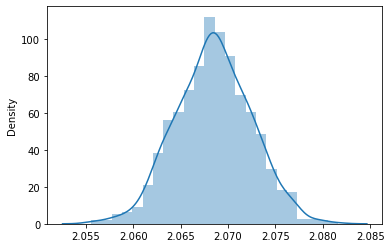

In [10]:
sns.distplot(means);

In [11]:
np.mean(means), df['Target'].mean()

(2.0684734136440013, 2.0685581690891843)

<p>В машинном обучении, метод бустрепа позволяет генерировать различные выборки, на основе которых мы можем учить алгоритмы и объеденять их предсказания, самым простым методом объеденения является среднее</p>
<img src="./img/bootstrap-learn.png">

In [12]:
train_X, valid_X, train_y, valid_y = train_test_split(df.drop('Target', axis=1), df['Target'], train_size=0.7)

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('estimator', KNeighborsRegressor(n_neighbors=3))
])
pipeline.fit(train_X, train_y)
predicts = pipeline.predict(valid_X)
np.sqrt(mean_squared_error(valid_y, predicts))

0.6660947266632092

In [15]:
valid_y.mean()

2.062597605360889

In [16]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('estimator', KNeighborsRegressor(n_neighbors=3))
        ])
    pipeline.fit(train_X, train_y)
    predicts[i] = pipeline.predict(valid_X)

In [17]:
np.sqrt(mean_squared_error(valid_y, predicts.mean(0)))

0.6660947266632092

In [18]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('estimator', KNeighborsRegressor(n_neighbors=3))
        ])
    idx = np.random.choice(np.arange(train_X.shape[0]), train_X.shape[0], replace=True)
    pipeline.fit(train_X.iloc[idx], train_y.iloc[idx])
    predicts[i] = pipeline.predict(valid_X)

In [19]:
np.sqrt(mean_squared_error(valid_y, predicts.mean(0)))

0.6132515401598315

In [43]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = Pipeline(
        [
            ('scaler', StandardScaler()), 
            ('estimator', KNeighborsRegressor(n_neighbors=1))
        ])
    idx = np.random.choice(np.arange(train_X.shape[0]), train_X.shape[0], replace=True)
    cols = list(np.random.choice(list(train_X.columns), int(0.8 * train_X.shape[1]), replace=False))
    pipeline.fit(train_X[cols].iloc[idx], train_y.iloc[idx])
    predicts[i] = pipeline.predict(valid_X[cols])

In [44]:
np.sqrt(mean_squared_error(valid_y, predicts.mean(0)))

0.5762008009679468

# Бэггинг 

<p>Как видно из примера аггрегация предсказаний регрессоров на разных подвыборках, дает прирост в 0.05</p>
<p>Без бутстрепа у нас не получилось бы аггрегировать предсказания, поскольку тренировка на однаковых данных давала бы одинаковый результат</p>
<p>Если мы предположим что каждый из классификаторов дает предсказание с вероятностью 80%, то объеденение 5 классификаторов будет давать корректную оценку в:</p>
<p><center>$$\large{0.8^5 + C^4_50.8^40.2 + C^3_50.8^30.2^2 = 0.942}$$</center></p>
<p><center>$$\large{\mu = \sum_{i>\frac{N}{2}}^{N}C^i_Np^i(1-p)^{N-i}}$$</center></p>
<p>Данный подход назывется <b>бэггинг</b></p>
<p>Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.</p>

In [33]:
from sklearn.ensemble import BaggingRegressor

In [35]:
pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', KNeighborsRegressor(n_neighbors=3))])
ensemble = BaggingRegressor(base_estimator=pipeline, n_estimators=50, n_jobs=-1, max_features=0.8, max_samples=1.0)

In [36]:
ensemble.fit(train_X, train_y)

BaggingRegressor(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                ('estimator',
                                                 KNeighborsRegressor(n_neighbors=3))]),
                 max_features=0.8, n_estimators=50, n_jobs=-1)

In [38]:
predicts = ensemble.predict(valid_X)
np.sqrt(mean_squared_error(valid_y, predicts))

0.5801431646433869

# Случайный лес

<p>Деревья решений являются хорошими кандидатами в качестве базового алгоритма для бэггинга, поскольку они могут достигать нулевой ошибки на тренировочных данных и строить достаточно сложные границы</p>
<p>Так же будем использовать не только различные подвыборки семплов, но и признаков для них, это позволяет обучать алгоритмы более независимо, тогда наша модель тренироваться следующим образом</p>

- От 1 до N (число деревьев)
- - Сгенировать выборку $\large{X_n}$ с помощью бустрепа
- - Обучить дерево решений на данной выборке

<p>Предсказания же получаются:</p>

- От 1 до N (число деревьев)
- - Получить ответ на дереве решений и добавить его в список
- Вернуть среднее списка

In [40]:
pipeline = DecisionTreeRegressor()
pipeline.fit(train_X, train_y)
predicts = pipeline.predict(valid_X)
np.sqrt(mean_squared_error(valid_y, predicts))

0.7313563181598863

In [41]:
predicts = np.zeros((50, valid_X.shape[0]))
for i in range(50):
    pipeline = DecisionTreeRegressor()
    idx = np.random.choice(train_X.index, train_X.shape[0], replace=True)
    feature_idx = np.random.choice(train_X.columns, int(train_X.shape[1]*0.8), replace=False)
    pipeline.fit(train_X.loc[idx, feature_idx], train_y.loc[idx])
    predicts[i] = pipeline.predict(valid_X[feature_idx])

In [42]:
np.sqrt(mean_squared_error(valid_y, predicts.mean(0)))

0.5019016861985931

<p>Теоретически случайный лес обладает таким же смещением, а увеличение качества достигается за счет уменьшения дисперсии</p>

## Параметры случайного леса

<p>Параметры случайного леса аналогичны параметрам деревьев решений, только добавляется параметр количества деревьев</p>

- n_estimators - количество деревьев в ансамбле
- criterion - критерий качества для разбиения в деревьях
- min_samples_split - минимальное количество семплов в ноде для дальнейшего ее разбиения
- min_samples_leaf - минимальное количество семплов в листе после разбиения
- min_weight_fraction_leaf - минимальная доля веса в листе после разбиения
- max_features - количество признаков которое используется при каждом разбиении (по умолчанию $\sqrt{N}$)
- max_leaf_nodes - максимальное количество листов в дереве
- min_impurity_decrease - минимальное изменение параметра качества чтобы сделать разбиение
- oob_score - проверка качестве модели на данных которые не попали в семплы для текущего дерева

In [45]:
ensemble = RandomForestRegressor(n_estimators=50, max_features=0.8)

In [46]:
parametrs = {'n_estimators': [50, 100, 150, 200],
             'min_samples_split': [3, 5, 10, 15],
             'max_features': np.linspace(0.7, 1, 4),
             'max_depth': np.arange(4, 11)}

cv = GridSearchCV(RandomForestRegressor(), parametrs, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
cv.fit(train_X, train_y)

In [ ]:
np.sqrt(cv.best_score_)

In [ ]:
cv.best_params_

In [ ]:
ensemble = cv.best_estimator_
parametrs = cv.best_params_

In [26]:
ensemble.fit(train_X, train_y)
predicts = ensemble.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.28692320478144934

## Сверхслучайные деревья

<p>Так же существует реализация сверхслучайных деревьев, в данном алгоритме при подсчете разбиения выбирается не лучшее среди всех разбиений, а лучшее из случайного набора разбиений</p>
<p>Данная имплементация обладает большем смещением, но меньшей дисперсией и может быть использована если обычный случайный лес или градиентый бустинг переобучаются</p>
<p>В <i>sklearn</i> за сверхслучайные деревья отвечают классы: <i>ExtraTreesClassifier</i>, <i>ExtraTreesRegressor</i></p>

In [27]:
ensemble = ExtraTreesRegressor(n_estimators=50, max_features=0.8)
ensemble.fit(train_X, train_y)
predicts = ensemble.predict(valid_X)
mean_squared_error(valid_y, predicts)

0.24862942461647897

## Зависимость качества классификации от параметров леса

### N_estimators

In [28]:
scores_valid = []
scores_train = []
for n_est in np.arange(10, 110, 10):
    ensemble = RandomForestRegressor(n_estimators=n_est)
    ensemble.fit(train_X, train_y)
    predicts_valid = ensemble.predict(valid_X)
    predicts_train = ensemble.predict(train_X)
    scores_valid.append(mean_squared_error(valid_y, predicts_valid))
    scores_train.append(mean_squared_error(train_y, predicts_train))

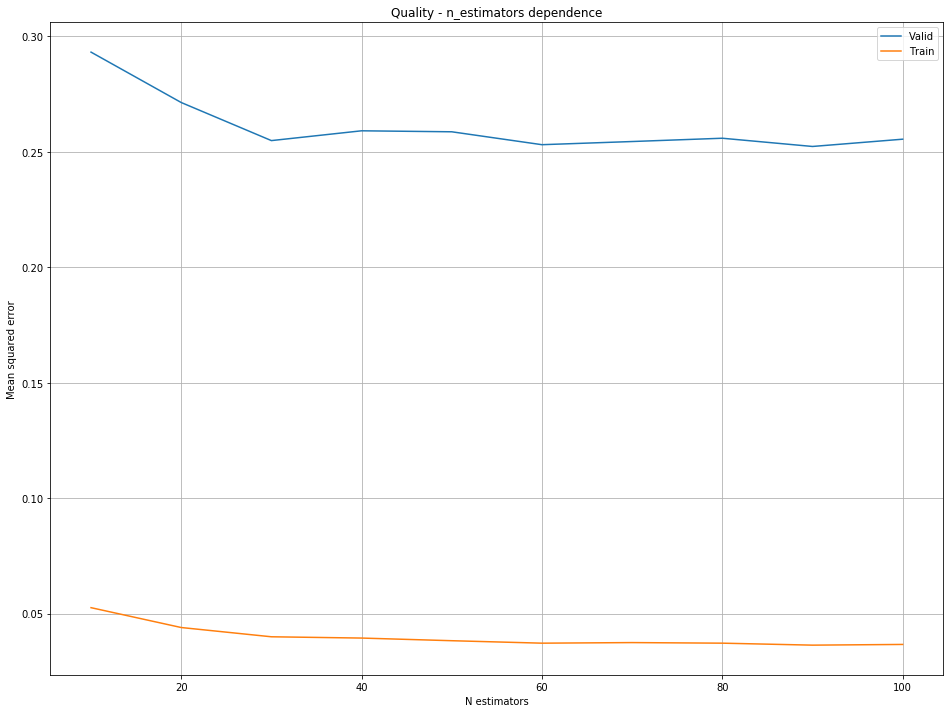

In [29]:
plt.figure(figsize=(16, 12));
plt.plot(np.arange(10, 110, 10), scores_valid, label='Valid');
plt.plot(np.arange(10, 110, 10), scores_train, label='Train');
plt.xlabel('N estimators');
plt.ylabel('Mean squared error');
plt.grid(True);
plt.legend();
plt.title('Quality - n_estimators dependence');

### Max depth

In [30]:
scores_valid = []
scores_train = []
for depth in np.arange(4, 16):
    ensemble = RandomForestRegressor(max_depth=depth, n_estimators=50)
    ensemble.fit(train_X, train_y)
    predicts_valid = ensemble.predict(valid_X)
    predicts_train = ensemble.predict(train_X)
    scores_valid.append(mean_squared_error(valid_y, predicts_valid))
    scores_train.append(mean_squared_error(train_y, predicts_train))

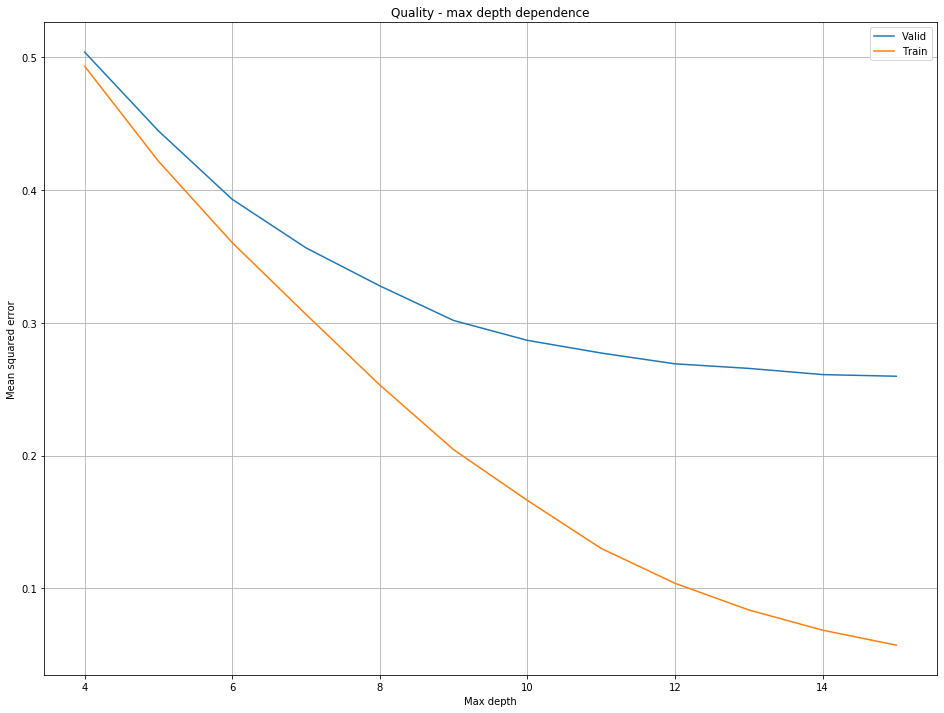

In [31]:
plt.figure(figsize=(16, 12));
plt.plot(np.arange(4, 16), scores_valid, label='Valid');
plt.plot(np.arange(4, 16), scores_train, label='Train');
plt.xlabel('Max depth');
plt.ylabel('Mean squared error');
plt.grid(True);
plt.legend();
plt.title('Quality - max depth dependence');

### Min samples split

In [32]:
scores_valid = []
scores_train = []
for min_sample in np.arange(5, 51, 5):
    ensemble = RandomForestRegressor(min_samples_split=min_sample, n_estimators=50)
    ensemble.fit(train_X, train_y)
    predicts_valid = ensemble.predict(valid_X)
    predicts_train = ensemble.predict(train_X)
    scores_valid.append(mean_squared_error(valid_y, predicts_valid))
    scores_train.append(mean_squared_error(train_y, predicts_train))

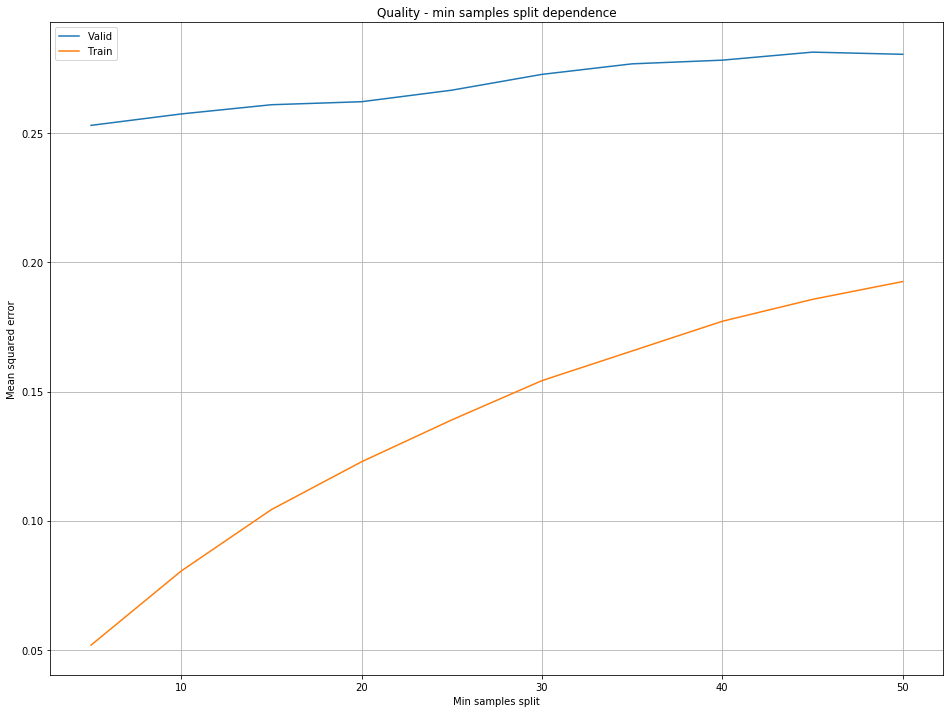

In [33]:
plt.figure(figsize=(16, 12));
plt.plot(np.arange(5, 51, 5), scores_valid, label='Valid');
plt.plot(np.arange(5, 51, 5), scores_train, label='Train');
plt.xlabel('Min samples split');
plt.ylabel('Mean squared error');
plt.grid(True);
plt.legend();
plt.title('Quality - min samples split dependence');

## Плюсы и минусы случайного леса

#### Плюсы

- имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
- практически не чувствителен к выбросам в данных из-за случайного сэмлирования
- не чувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
- не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
- способен эффективно обрабатывать данные с большим числом признаков и классов
- одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
- редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
- для случайного леса существуют методы оценивания значимости отдельных признаков в модели
- хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
- предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
- вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
- возможности, описанные выше, могут быть расширены до неразмеченных данных, что приводит к возможности делать кластеризацию и визуализацию данных, обнаруживать выбросы
- высокая параллелизуемость и масштабируемость.


#### Минусы:

- в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
- нет формальных выводов (p-values), доступных для оценки важности переменных
- алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
- случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
- алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
- для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение оптимизируемого функционала (типа прироста информации)
- если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
- больший размер получающихся моделей. Требуется  памяти $\large{O(NK)}$ для хранения модели, где $\large{K}$ — число деревьев.

<p><a href="https://habr.com/ru/company/ods/blog/324402/">Статья на хабре о случайном лесе</a></p>